## Librerias

In [2]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Sin balanceo de clases

## Generación de Datos

##### Grafico de la distribución de las clases

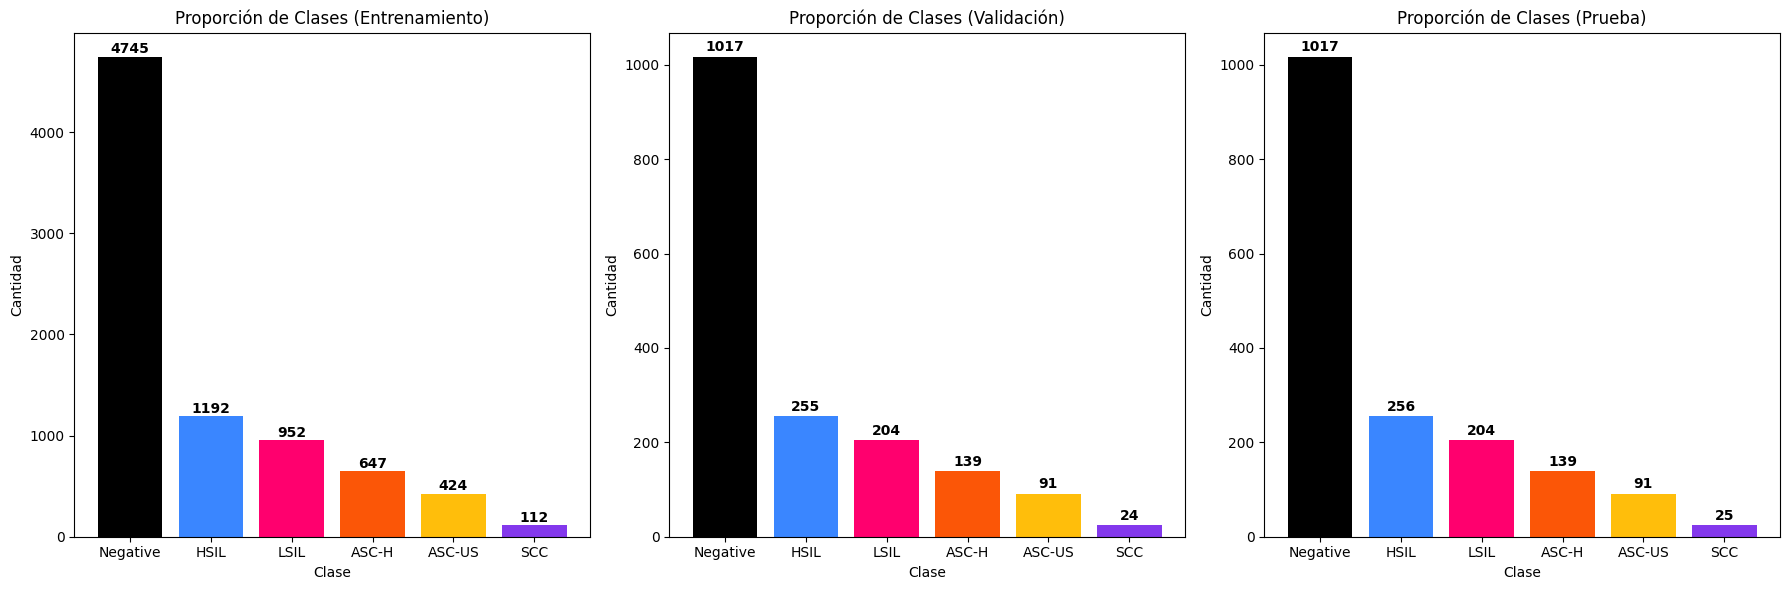

In [33]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes por clase dentro de "lesion" y "no lesion" en el nuevo formato
def count_images_by_class(folder_path):
    # Diccionario para almacenar el conteo de cada clase
    class_counts = {}

    # Contar imágenes en la carpeta "0_no_lesion/Negative"
    no_lesion_folder = os.path.join(folder_path, '0_no_lesion', 'Negative')
    class_counts['Negative'] = len(os.listdir(no_lesion_folder)) if os.path.exists(no_lesion_folder) else 0

    # Contar imágenes en cada subcarpeta de "1_lesion"
    lesion_folder = os.path.join(folder_path, '1_lesion')
    for lesion_class in os.listdir(lesion_folder):
        lesion_class_path = os.path.join(lesion_folder, lesion_class)
        if os.path.isdir(lesion_class_path):
            class_counts[lesion_class] = len(os.listdir(lesion_class_path))

    return class_counts

# Función para crear gráficos de barras para las proporciones de cada clase
def plot_class_proportion(ax, class_counts, title, colors):
    # Crear el gráfico de barras en el subplot
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    ax.bar(classes, counts, color=colors[:len(classes)])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    for i, count in enumerate(counts):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops/train'
val_dir = 'crops/val'
test_dir = 'crops/test'

# Contar las imágenes en cada conjunto por clase
train_class_counts = count_images_by_class(train_dir)
val_class_counts = count_images_by_class(val_dir)
test_class_counts = count_images_by_class(test_dir)

# Colores para cada clase
colors = ['#000000', '#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC']  # Negro para 'Negative' y colores para las clases con lesión

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_class_proportion(axes[0], train_class_counts, 'Proporción de Clases (Entrenamiento)', colors)
plot_class_proportion(axes[1], val_class_counts, 'Proporción de Clases (Validación)', colors)
plot_class_proportion(axes[2], test_class_counts, 'Proporción de Clases (Prueba)', colors)

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

#### Generadores

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de los generadores de datos sin aumentación, solo reescalado
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de imágenes para entrenamiento en modo multiclase
train_generator = train_datagen.flow_from_directory(
    'crops_5classes/train',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', 
    shuffle=True
)

# Generador de imágenes para validación en modo multiclase
val_generator = val_test_datagen.flow_from_directory(
    'crops_5classes/val',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generador de imágenes para prueba en modo multiclase
test_generator = val_test_datagen.flow_from_directory(
    'crops_5classes/test', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3327 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 715 images belonging to 5 classes.


## Modelos

### Modelo EfficientNetB0

In [107]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten

num_classes = train_generator.num_classes

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(input_shape=(90, 90, 3), include_top=False, weights='imagenet', classes= num_classes)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, outputs)


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_B0 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2024-10-26 15:53:55.496789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - ETA: 0s - loss: 1.4258 - accuracy: 0.4518 - precision: 0.5150 - recall: 0.3466 - auc: 0.7679

2024-10-26 15:54:38.029494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 45s 307ms/step - loss: 1.4258 - accuracy: 0.4518 - precision: 0.5150 - recall: 0.3466 - auc: 0.7679 - val_loss: 1.7428 - val_accuracy: 0.3268 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5164 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 31s 300ms/step - loss: 1.0944 - accuracy: 0.5612 - precision: 0.6215 - recall: 0.4788 - auc: 0.8565 - val_loss: 1.6796 - val_accuracy: 0.2763 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5443 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 31s 294ms/step - loss: 0.9599 - accuracy: 0.6174 - precision: 0.6646 - recall: 0.5377 - auc: 0.8863 - val_loss: 1.6506 - val_accuracy: 0.2665 - val_precision: 0.2400 - val_recall: 0.0337 - val_auc: 0.6007 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 31s 293ms/step - loss: 0.8228 - accuracy: 0.6724 - precision: 0.7176 - recall: 0.6072 - auc: 0.9149 - val_loss: 1

#### Evaluación

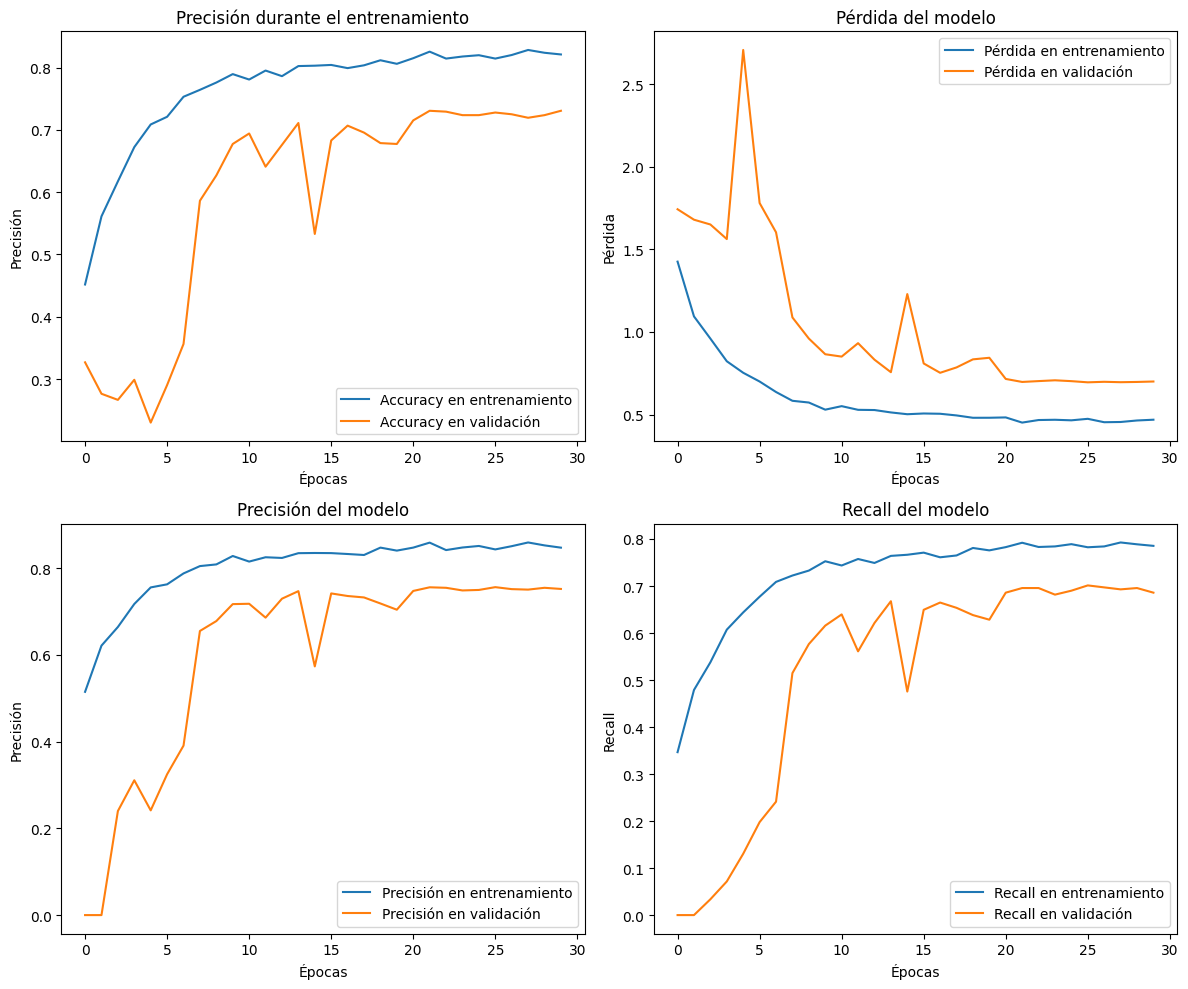

In [108]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_B0.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_B0.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_B0.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_B0.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_B0.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_B0.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_B0.history['recall'], label='Recall en entrenamiento')
plt.plot(history_B0.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

In [109]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

 2/23 [=>............................] - ETA: 1s - loss: 0.7446 - accuracy: 0.7344 - precision: 0.7344 - recall: 0.7344 - auc: 0.9276

2024-10-26 16:09:20.445638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 2s 75ms/step - loss: 0.7640 - accuracy: 0.7147 - precision: 0.7442 - recall: 0.6755 - auc: 0.9287
Test Loss: 0.7640268802642822
Test Accuracy: 0.714685320854187
Test Precision: 0.7442218661308289
Test Recall: 0.6755244731903076
Test AUC: 0.9287182688713074


**Matriz de confusión**

2024-10-26 16:09:22.263827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 3s 77ms/step


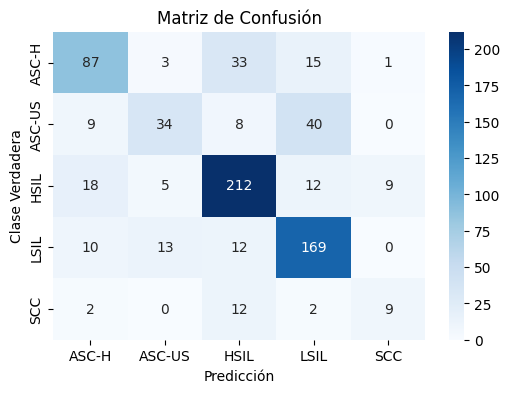

In [110]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

 1/23 [>.............................] - ETA: 2s

2024-10-26 16:09:25.339648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 2s 78ms/step


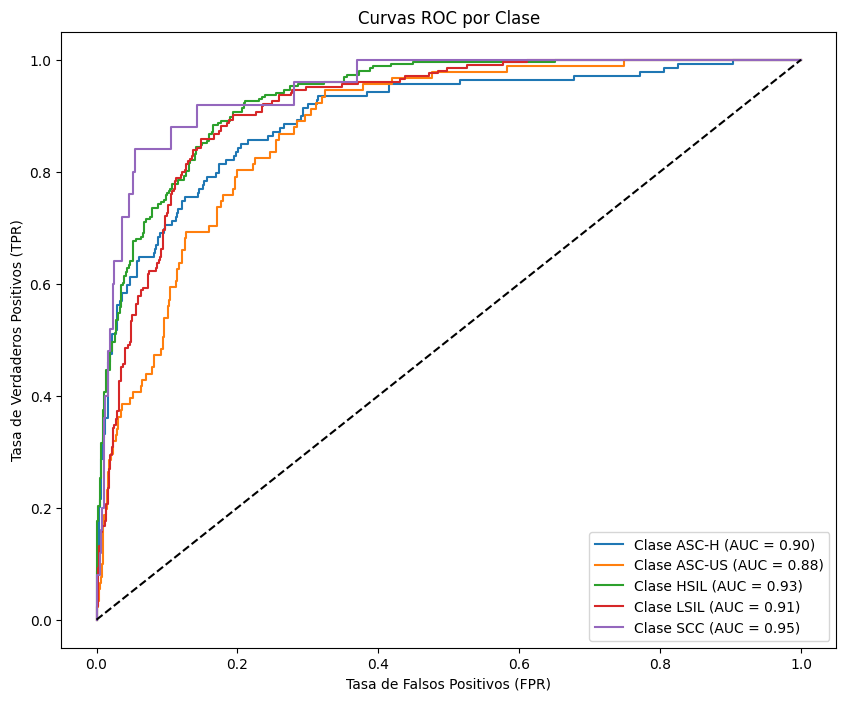

AUC Promedio: 0.91
AUC Promedio Ponderado: 0.91


In [111]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo EfficientNetB4 

In [112]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten

num_classes = train_generator.num_classes

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB4(input_shape=(90, 90, 3), include_top=False, weights='imagenet', classes= num_classes)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, outputs)


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_B4 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2024-10-26 16:09:29.957895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - ETA: 0s - loss: 1.2922 - accuracy: 0.4911 - precision: 0.5602 - recall: 0.3694 - auc: 0.7964

2024-10-26 16:11:31.777919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 131s 1s/step - loss: 1.2922 - accuracy: 0.4911 - precision: 0.5602 - recall: 0.3694 - auc: 0.7964 - val_loss: 1.5185 - val_accuracy: 0.3380 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6401 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 100s 960ms/step - loss: 1.0721 - accuracy: 0.5618 - precision: 0.6169 - recall: 0.4773 - auc: 0.8593 - val_loss: 1.4724 - val_accuracy: 0.3647 - val_precision: 0.4091 - val_recall: 0.0126 - val_auc: 0.6725 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 100s 963ms/step - loss: 0.9597 - accuracy: 0.6183 - precision: 0.6744 - recall: 0.5335 - auc: 0.8859 - val_loss: 1.5270 - val_accuracy: 0.3254 - val_precision: 0.4011 - val_recall: 0.1052 - val_auc: 0.6708 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 100s 965ms/step - loss: 0.8299 - accuracy: 0.6706 - precision: 0.7232 - recall: 0.6008 - auc: 0.9133 - val_loss: 1.6921 -

#### Evaluación

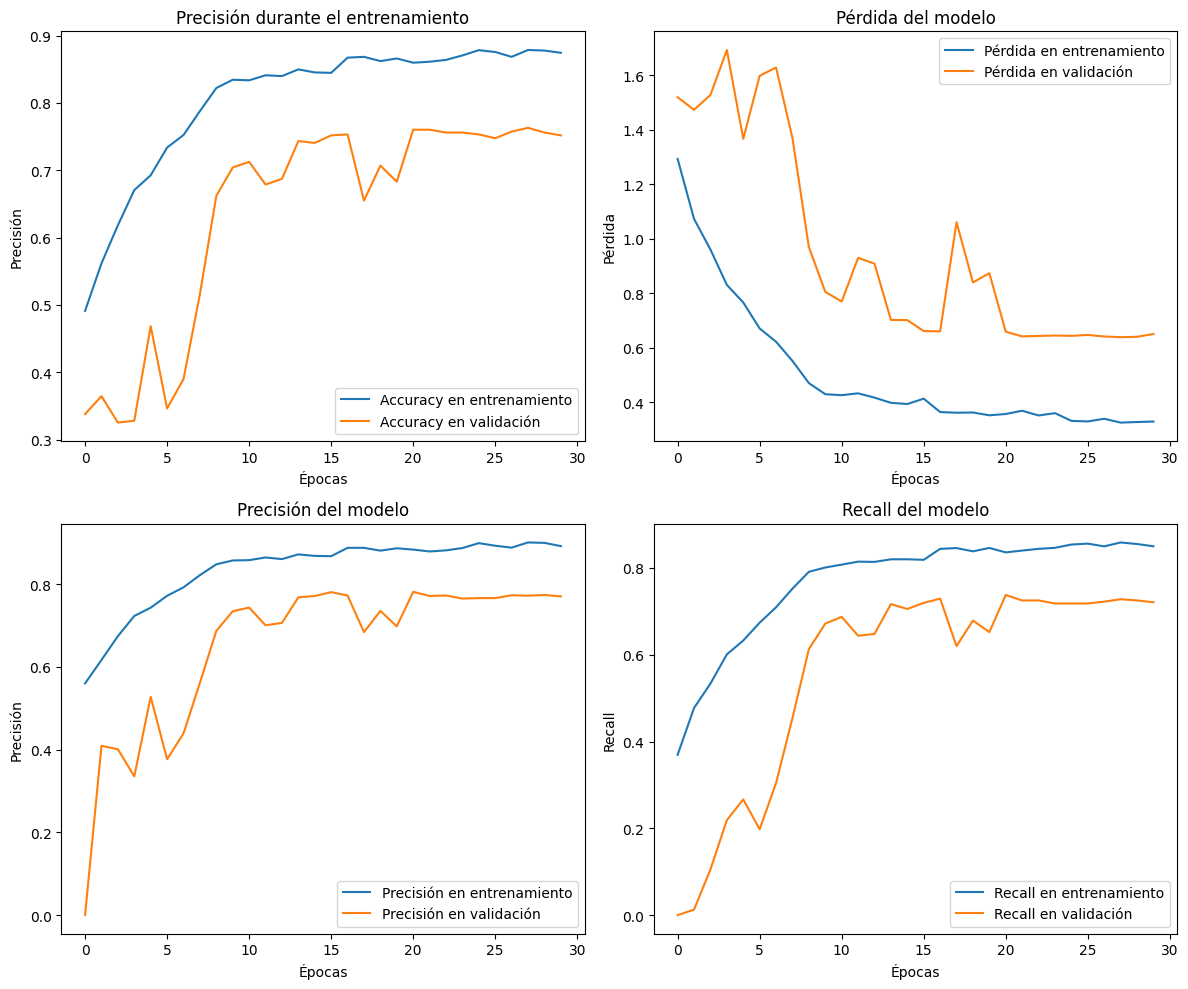

In [113]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_B4.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_B4.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_B4.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_B4.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_B4.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_B4.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_B4.history['recall'], label='Recall en entrenamiento')
plt.plot(history_B4.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

In [114]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

2024-10-26 16:59:43.298170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 5s 220ms/step - loss: 0.7950 - accuracy: 0.7119 - precision: 0.7349 - recall: 0.6825 - auc: 0.9298
Test Loss: 0.7949990630149841
Test Accuracy: 0.7118881344795227
Test Precision: 0.7349397540092468
Test Recall: 0.6825174689292908
Test AUC: 0.9297931790351868


**Matriz de confusión**

2024-10-26 16:59:48.476949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 7s 223ms/step


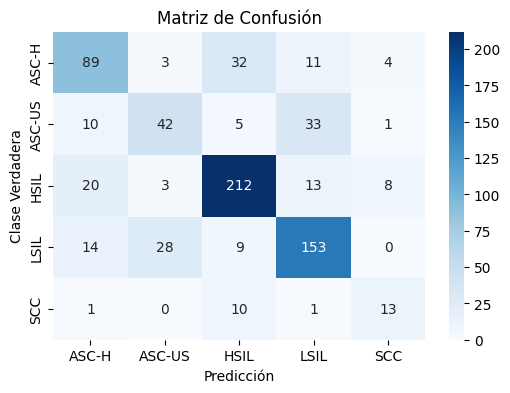

In [115]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

2024-10-26 16:59:56.017180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 5s 229ms/step


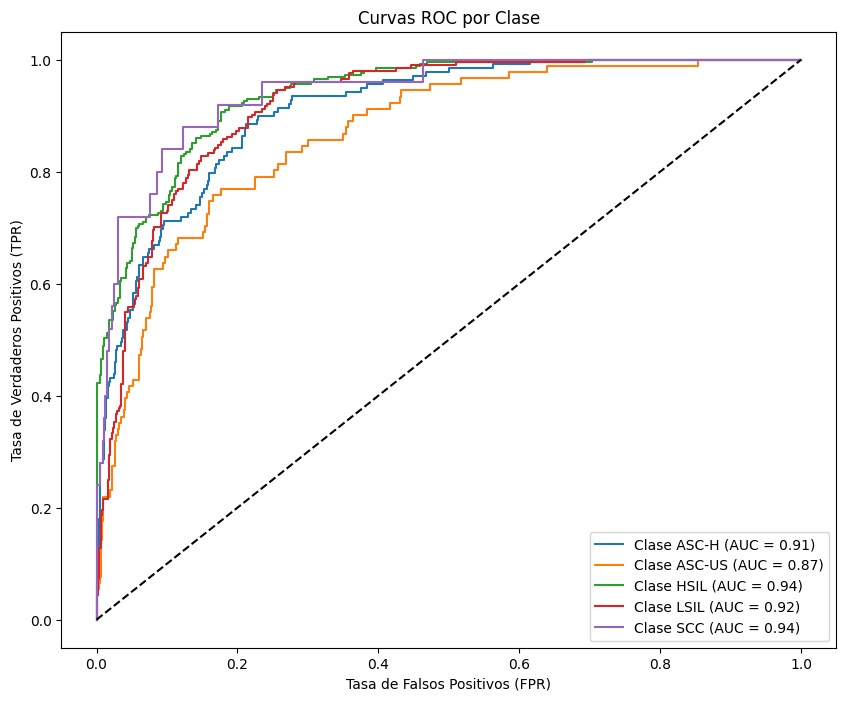

AUC Promedio: 0.92
AUC Promedio Ponderado: 0.92


In [116]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo EfficientNetB5 

In [117]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten

num_classes = train_generator.num_classes

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB5(input_shape=(90, 90, 3), include_top=False, weights='imagenet', classes= num_classes)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, outputs)


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_B5 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2024-10-26 17:00:04.792388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - ETA: 0s - loss: 1.3172 - accuracy: 0.4683 - precision: 0.5502 - recall: 0.3411 - auc: 0.7855

2024-10-26 17:03:25.598600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 211s 2s/step - loss: 1.3172 - accuracy: 0.4683 - precision: 0.5502 - recall: 0.3411 - auc: 0.7855 - val_loss: 1.6369 - val_accuracy: 0.3576 - val_precision: 0.3967 - val_recall: 0.2048 - val_auc: 0.6384 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 173s 2s/step - loss: 1.0210 - accuracy: 0.5909 - precision: 0.6452 - recall: 0.5035 - auc: 0.8713 - val_loss: 1.8961 - val_accuracy: 0.2917 - val_precision: 0.3478 - val_recall: 0.1683 - val_auc: 0.5244 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 170s 2s/step - loss: 0.8767 - accuracy: 0.6549 - precision: 0.7065 - recall: 0.5717 - auc: 0.9031 - val_loss: 2.5964 - val_accuracy: 0.3548 - val_precision: 0.3478 - val_recall: 0.3156 - val_auc: 0.5808 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 170s 2s/step - loss: 0.7476 - accuracy: 0.6988 - precision: 0.7422 - recall: 0.6324 - auc: 0.9282 - val_loss: 2.1866 - val_accuracy: 0.

#### Evaluación

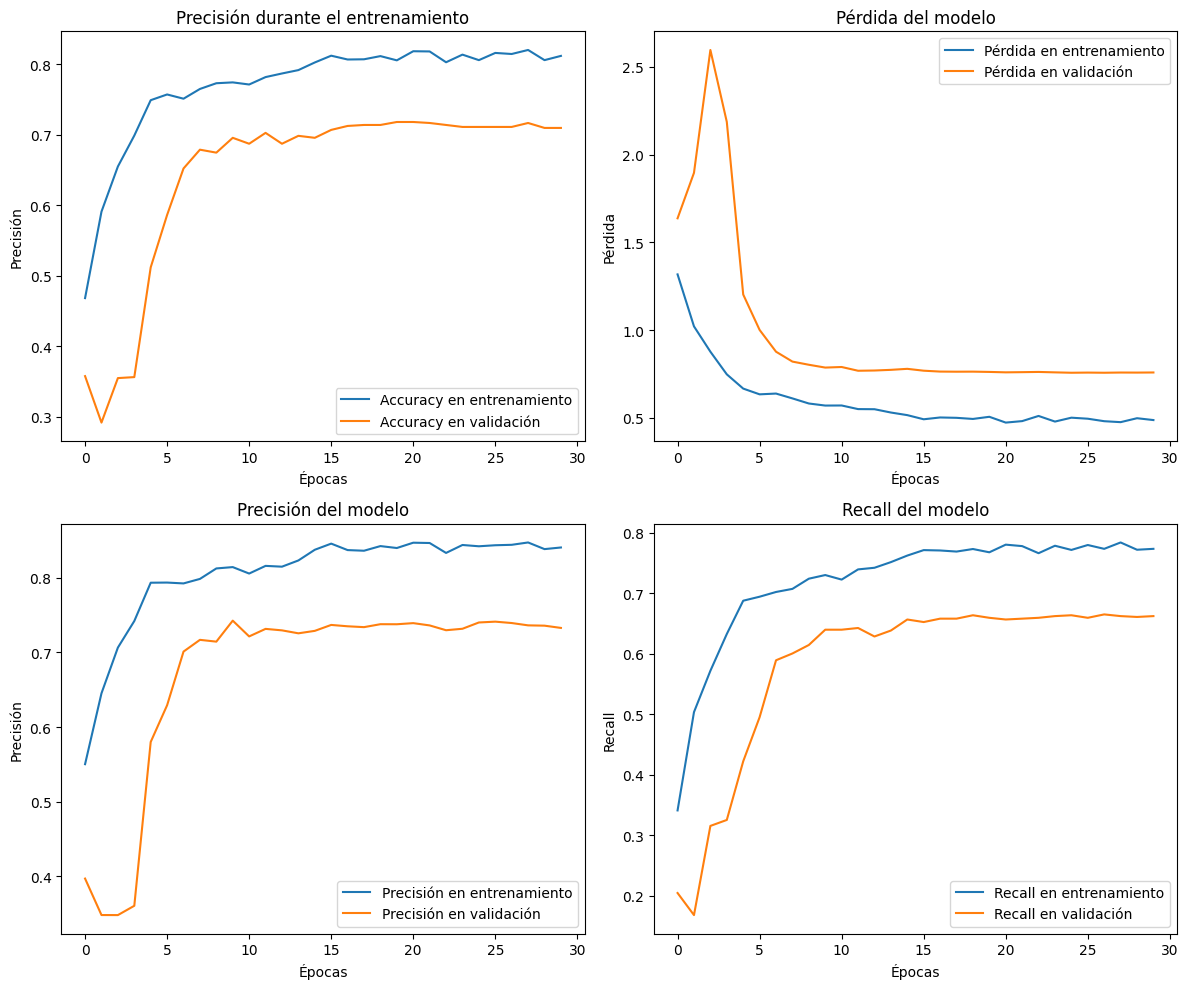

In [118]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_B5.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_B5.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_B5.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_B5.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_B5.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_B5.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_B5.history['recall'], label='Recall en entrenamiento')
plt.plot(history_B5.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

In [119]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

2024-10-26 18:25:07.021090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 8s 323ms/step - loss: 0.8240 - accuracy: 0.6573 - precision: 0.7003 - recall: 0.5916 - auc: 0.9148
Test Loss: 0.8240190744400024
Test Accuracy: 0.6573426723480225
Test Precision: 0.7003311514854431
Test Recall: 0.5916084051132202
Test AUC: 0.9147870540618896


**Matriz de confusión**

2024-10-26 18:25:14.621935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 10s 327ms/step


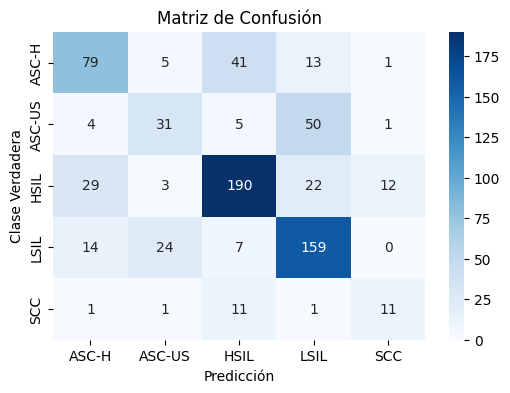

In [120]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

2024-10-26 18:25:24.961283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 8s 329ms/step


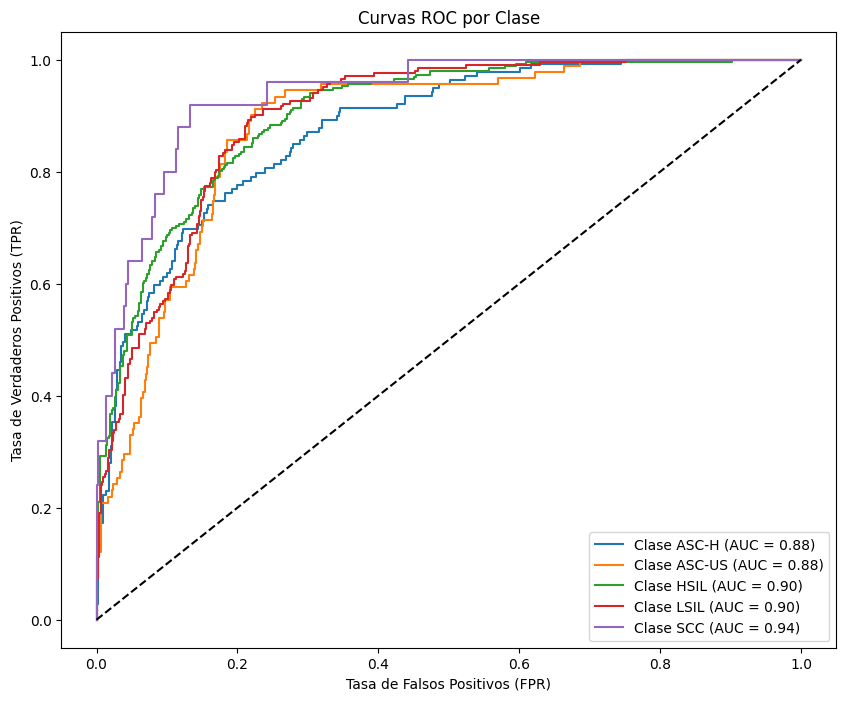

AUC Promedio: 0.90
AUC Promedio Ponderado: 0.89


In [121]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### MovileNetV2

In [122]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Construir el modelo de clasificación
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Clasificación multiclase
])

# Descongelar algunas capas del modelo base
for layer in base_model.layers[-10:]:
    layer.trainable = True


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_MN_V2 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/30


2024-10-26 18:25:33.830691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - ETA: 0s - loss: 1.7351 - accuracy: 0.3312 - precision: 0.3613 - recall: 0.1978 - auc: 0.6627

2024-10-26 18:25:44.752676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 13s 101ms/step - loss: 1.7351 - accuracy: 0.3312 - precision: 0.3613 - recall: 0.1978 - auc: 0.6627 - val_loss: 1.6526 - val_accuracy: 0.4137 - val_precision: 0.4468 - val_recall: 0.3240 - val_auc: 0.7419
Epoch 2/30
104/104 [==============================] - 9s 88ms/step - loss: 1.4657 - accuracy: 0.4139 - precision: 0.4730 - recall: 0.2341 - auc: 0.7314 - val_loss: 1.4799 - val_accuracy: 0.4292 - val_precision: 0.5000 - val_recall: 0.3310 - val_auc: 0.7605
Epoch 3/30
104/104 [==============================] - 9s 84ms/step - loss: 1.3327 - accuracy: 0.4527 - precision: 0.5196 - recall: 0.2546 - auc: 0.7697 - val_loss: 1.3284 - val_accuracy: 0.4769 - val_precision: 0.5477 - val_recall: 0.3142 - val_auc: 0.7866
Epoch 4/30
104/104 [==============================] - 9s 84ms/step - loss: 1.2750 - accuracy: 0.4602 - precision: 0.5490 - recall: 0.2675 - auc: 0.7863 - val_loss: 1.2571 - val_accuracy: 0.5063 - val_precision: 0.5667 - val_recall: 0.3338

#### Evaluación

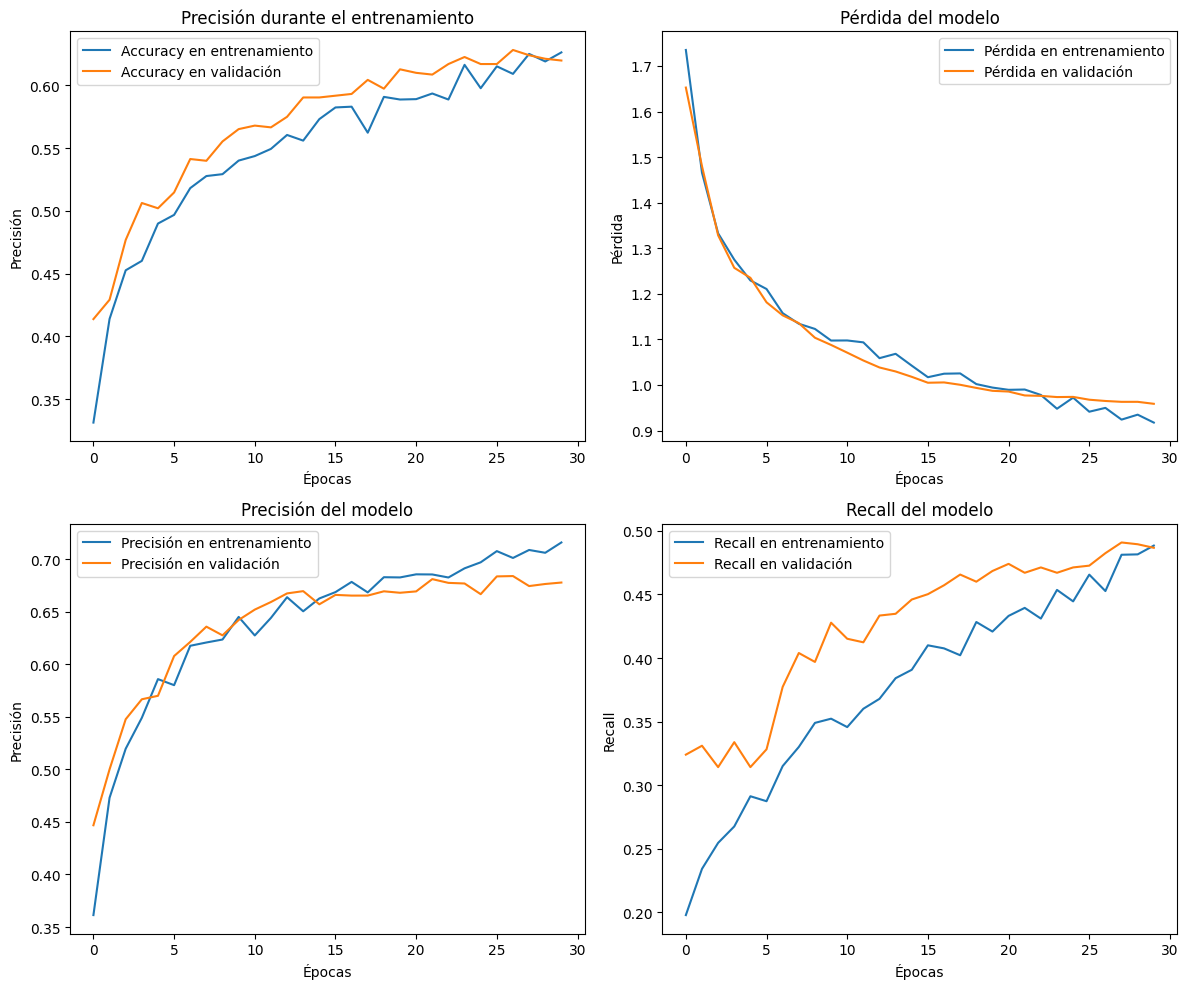

In [123]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_MN_V2.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_MN_V2.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_MN_V2.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_MN_V2.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_MN_V2.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_MN_V2.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_MN_V2.history['recall'], label='Recall en entrenamiento')
plt.plot(history_MN_V2.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()


In [124]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

 3/23 [==>...........................] - ETA: 0s - loss: 1.3207 - accuracy: 0.3646 - precision: 0.3065 - recall: 0.1979 - auc: 0.7617

2024-10-26 18:30:02.851501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 38ms/step - loss: 0.9847 - accuracy: 0.6056 - precision: 0.6653 - recall: 0.4671 - auc: 0.8731
Test Loss: 0.9847013354301453
Test Accuracy: 0.6055943965911865
Test Precision: 0.6653386354446411
Test Recall: 0.4671328663825989
Test AUC: 0.8731393218040466


**Matriz de confusión**

2024-10-26 18:30:03.809321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 38ms/step


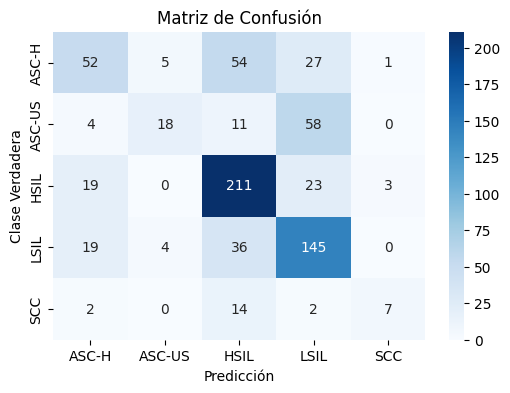

In [125]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

 3/23 [==>...........................] - ETA: 0s

2024-10-26 18:30:05.460616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 38ms/step


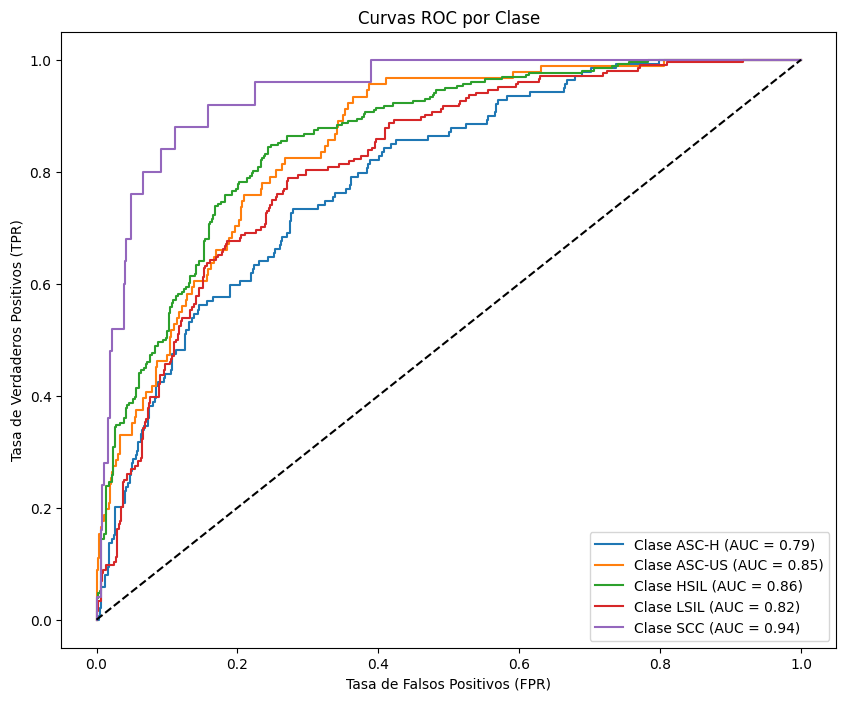

AUC Promedio: 0.85
AUC Promedio Ponderado: 0.84


In [126]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

 3/23 [==>...........................] - ETA: 0s

2024-10-26 18:30:06.586669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 38ms/step


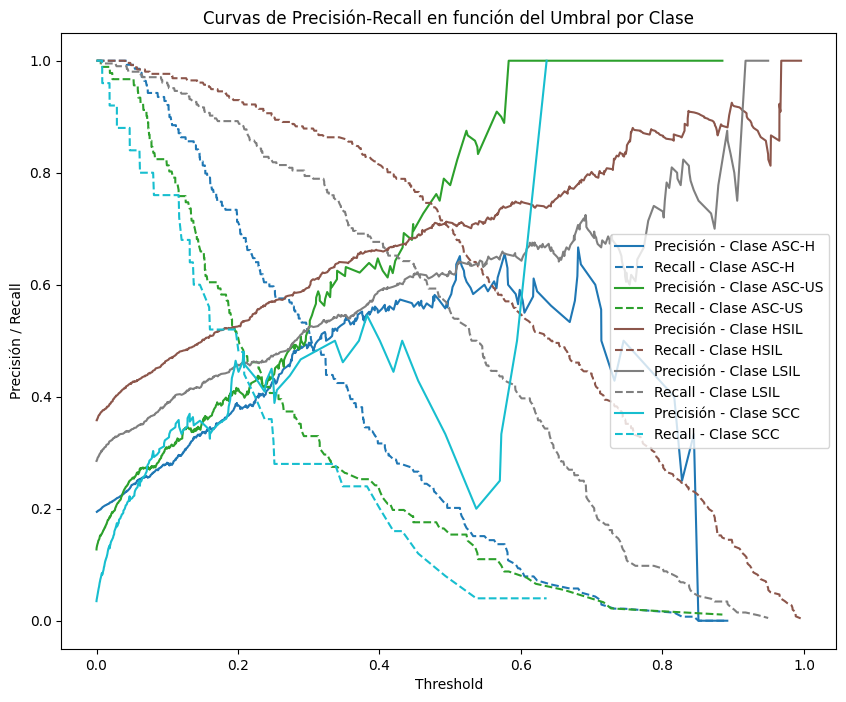

In [127]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_labels)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Definir un conjunto de colores para las clases
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

# Graficar precisión y recall en función del umbral para cada clase
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    precision, recall, thresholds = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    
    # Graficar precisión con línea continua
    plt.plot(thresholds, precision[:-1], label=f"Precisión - Clase {class_labels[i]}", color=color, linestyle='-')
    
    # Graficar recall con línea punteada
    plt.plot(thresholds, recall[:-1], label=f"Recall - Clase {class_labels[i]}", color=color, linestyle='--')

plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curvas de Precisión-Recall en función del Umbral por Clase")
plt.legend(loc="best")
plt.show()


### MovileNetV3

In [128]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV3Large(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Construir el modelo de clasificación
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Clasificación multiclase
])

# Descongelar algunas capas del modelo base
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_MN_V3 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2024-10-26 18:30:09.095465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - ETA: 0s - loss: 1.6140 - accuracy: 0.3553 - precision: 0.4088 - recall: 0.1139 - auc: 0.6656

2024-10-26 18:30:24.412465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 17s 102ms/step - loss: 1.6140 - accuracy: 0.3553 - precision: 0.4088 - recall: 0.1139 - auc: 0.6656 - val_loss: 1.5352 - val_accuracy: 0.3436 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6316 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 10s 91ms/step - loss: 1.4136 - accuracy: 0.4310 - precision: 0.4940 - recall: 0.1740 - auc: 0.7400 - val_loss: 1.5381 - val_accuracy: 0.2861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6334 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 9s 86ms/step - loss: 1.3732 - accuracy: 0.4406 - precision: 0.5231 - recall: 0.1972 - auc: 0.7543 - val_loss: 1.5865 - val_accuracy: 0.2861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6021 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 9s 86ms/step - loss: 1.3207 - accuracy: 0.4593 - precision: 0.5509 - recall: 0.2278 - auc: 0.7719 - val_loss

#### Evaluación

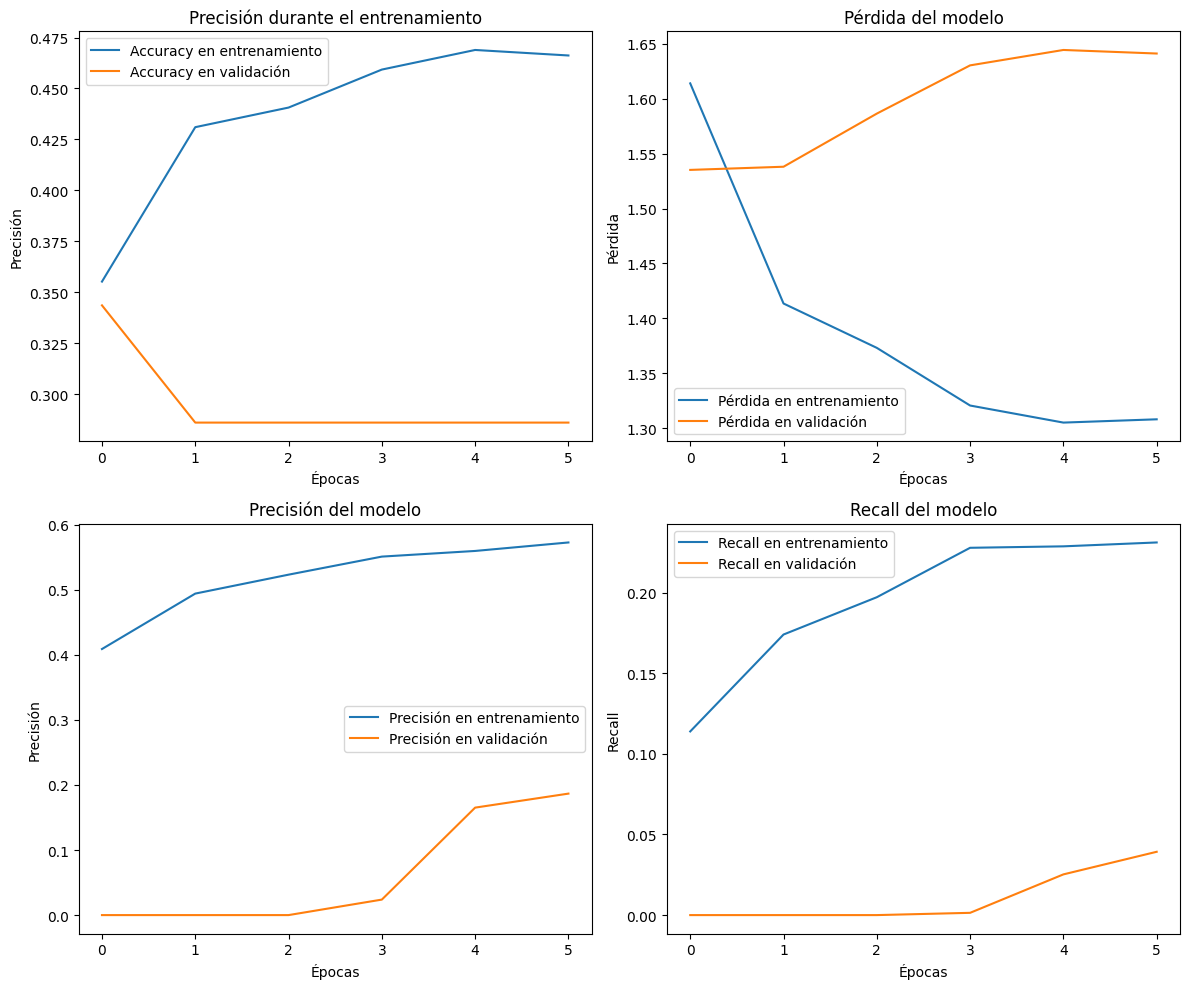

In [129]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_MN_V3.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_MN_V3.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_MN_V3.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_MN_V3.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_MN_V3.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_MN_V3.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_MN_V3.history['recall'], label='Recall en entrenamiento')
plt.plot(history_MN_V3.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

In [130]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

 3/23 [==>...........................] - ETA: 0s - loss: 2.0789 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0016

2024-10-26 18:31:12.080570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 33ms/step - loss: 1.5312 - accuracy: 0.3483 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6346
Test Loss: 1.5312366485595703
Test Accuracy: 0.3482517600059509
Test Precision: 0.0
Test Recall: 0.0
Test AUC: 0.6346474885940552


**Matriz de confusión**

2024-10-26 18:31:12.932817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 2s 39ms/step


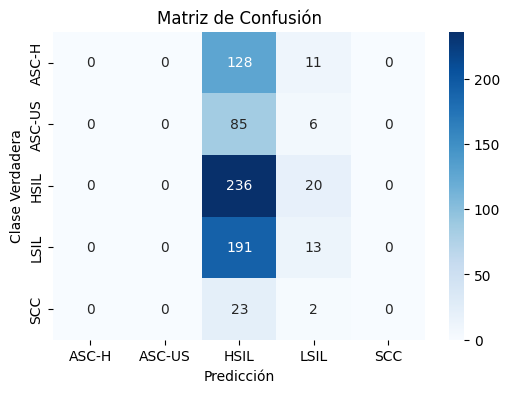

In [131]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

 3/23 [==>...........................] - ETA: 0s

2024-10-26 18:31:14.762233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 1s 36ms/step


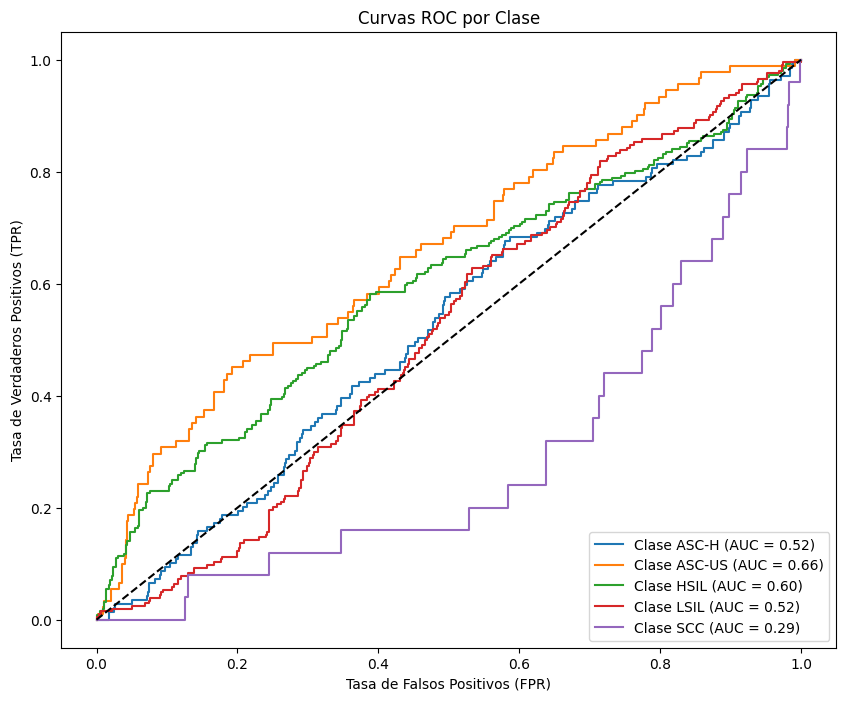

AUC Promedio: 0.52
AUC Promedio Ponderado: 0.56


In [132]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo InceptionV3

In [133]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten

num_classes = train_generator.num_classes

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = InceptionV3(input_shape=(90, 90, 3), include_top=False, weights='imagenet', classes= num_classes)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, outputs)


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_I_V3 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2024-10-26 18:31:17.414620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.4479 - precision: 0.6056 - recall: 0.1698 - auc: 0.7466

2024-10-26 18:32:09.941681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 56s 428ms/step - loss: 1.3675 - accuracy: 0.4479 - precision: 0.6056 - recall: 0.1698 - auc: 0.7466 - val_loss: 1.2615 - val_accuracy: 0.5231 - val_precision: 0.6576 - val_recall: 0.1697 - val_auc: 0.8035 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 44s 418ms/step - loss: 1.1103 - accuracy: 0.5503 - precision: 0.6739 - recall: 0.3622 - auc: 0.8419 - val_loss: 1.0100 - val_accuracy: 0.5933 - val_precision: 0.7136 - val_recall: 0.4264 - val_auc: 0.8714 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 44s 418ms/step - loss: 0.9941 - accuracy: 0.5846 - precision: 0.6755 - recall: 0.4442 - auc: 0.8738 - val_loss: 0.9666 - val_accuracy: 0.6255 - val_precision: 0.7290 - val_recall: 0.4979 - val_auc: 0.8836 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 44s 419ms/step - loss: 0.8798 - accuracy: 0.6435 - precision: 0.7211 - recall: 0.5332 - auc: 0.9010 - val_loss: 0.9016 - val_accu

#### Evaluación

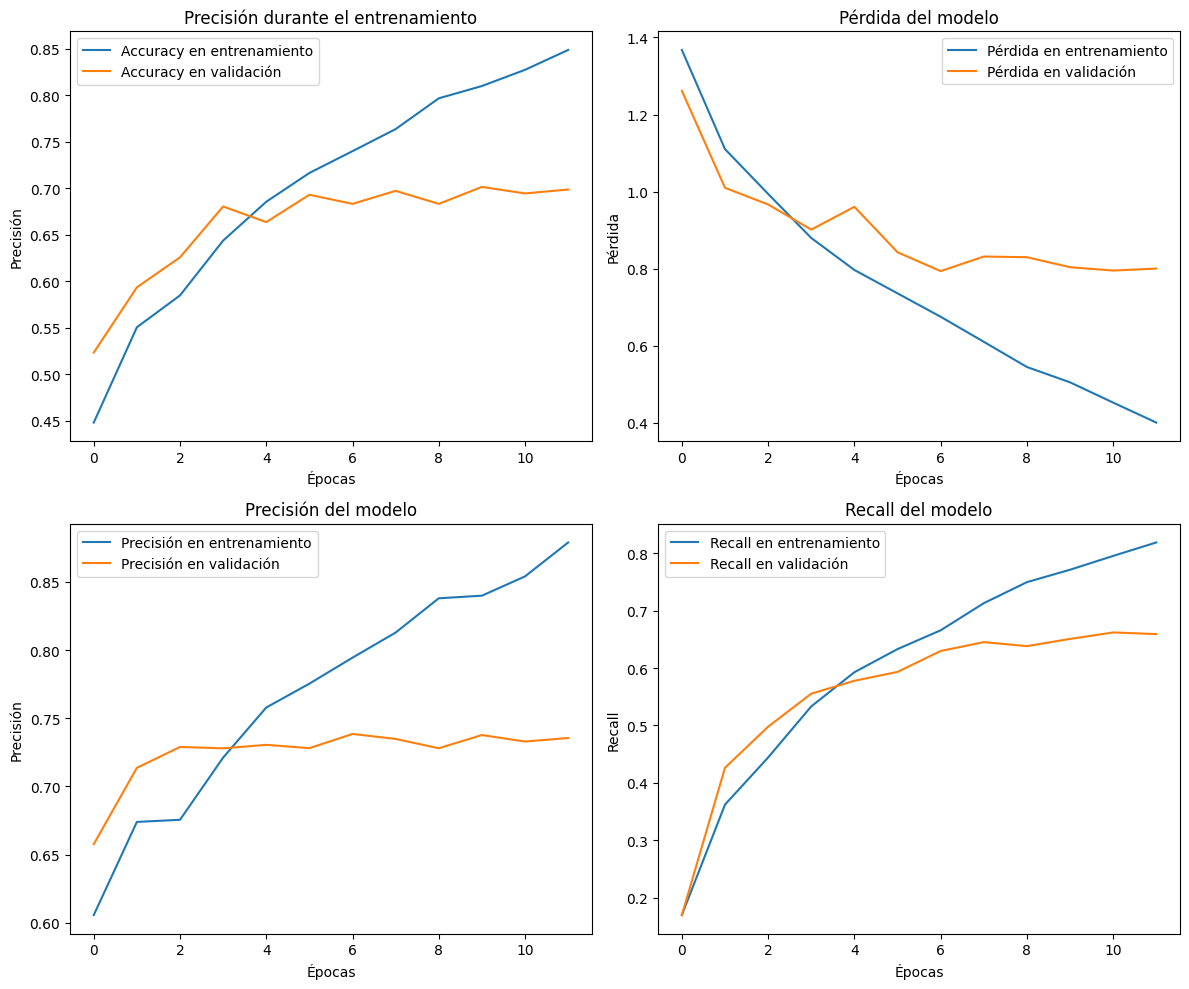

In [134]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_I_V3.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_I_V3.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_I_V3.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_I_V3.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_I_V3.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_I_V3.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_I_V3.history['recall'], label='Recall en entrenamiento')
plt.plot(history_I_V3.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

In [135]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

 1/23 [>.............................] - ETA: 3s - loss: 0.9705 - accuracy: 0.6250 - precision: 0.6818 - recall: 0.4688 - auc: 0.8822

2024-10-26 18:40:12.591987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 2s 102ms/step - loss: 0.8915 - accuracy: 0.6434 - precision: 0.7031 - recall: 0.5664 - auc: 0.9013
Test Loss: 0.891455352306366
Test Accuracy: 0.6433566212654114
Test Precision: 0.703125
Test Recall: 0.5664335489273071
Test AUC: 0.9013352394104004


**Matriz de confusión**

2024-10-26 18:40:15.034859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 3s 103ms/step


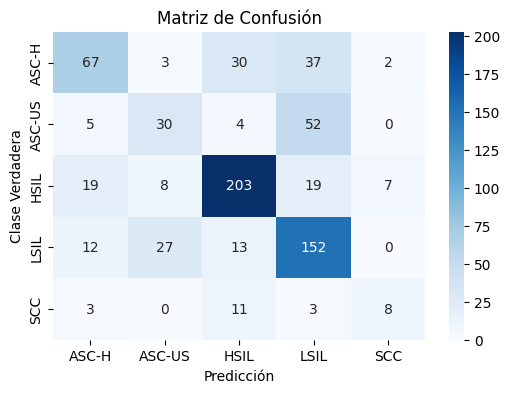

In [136]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

 1/23 [>.............................] - ETA: 3s

2024-10-26 18:40:18.498228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 2s 103ms/step


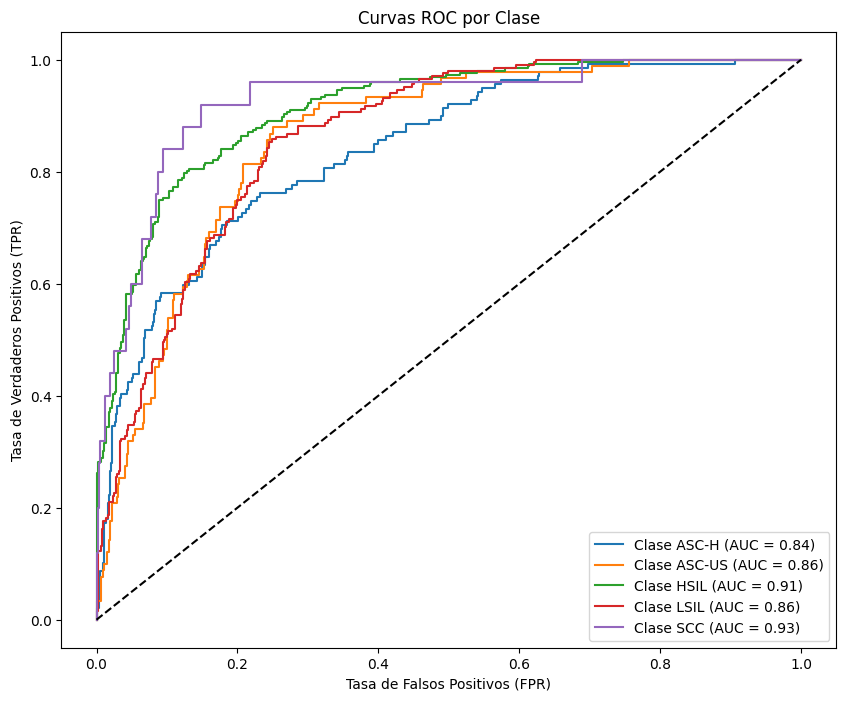

AUC Promedio: 0.88
AUC Promedio Ponderado: 0.88


In [137]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo Xception

In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

num_classes = train_generator.num_classes

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = Xception(input_shape=(224, 224, 3), include_top=False, weights='imagenet', classes= num_classes)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, outputs)


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_X = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
104/104 [==============================] - 458s 4s/step - loss: 1.0779 - accuracy: 0.5552 - precision: 0.6465 - recall: 0.3946 - auc: 0.8507 - val_loss: 1.0226 - val_accuracy: 0.6396 - val_precision: 0.6783 - val_recall: 0.6003 - val_auc: 0.8868 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 463s 4s/step - loss: 0.4102 - accuracy: 0.8500 - precision: 0.8861 - recall: 0.8115 - auc: 0.9787 - val_loss: 0.9130 - val_accuracy: 0.6872 - val_precision: 0.7141 - val_recall: 0.6550 - val_auc: 0.9119 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 451s 4s/step - loss: 0.1208 - accuracy: 0.9663 - precision: 0.9703 - recall: 0.9609 - auc: 0.9983 - val_loss: 0.7869 - val_accuracy: 0.7419 - val_precision: 0.7500 - val_recall: 0.7237 - val_auc: 0.9368 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 478s 5s/step - loss: 0.0395 - accuracy: 0.9916 - precision: 0.9925 - recall: 0.9901 - auc: 0.9999 - val_loss: 0.7912 - val_a

In [15]:
model.save('modelosFinales/xception_clasificacion5clases_2.keras')

#### Evaluación

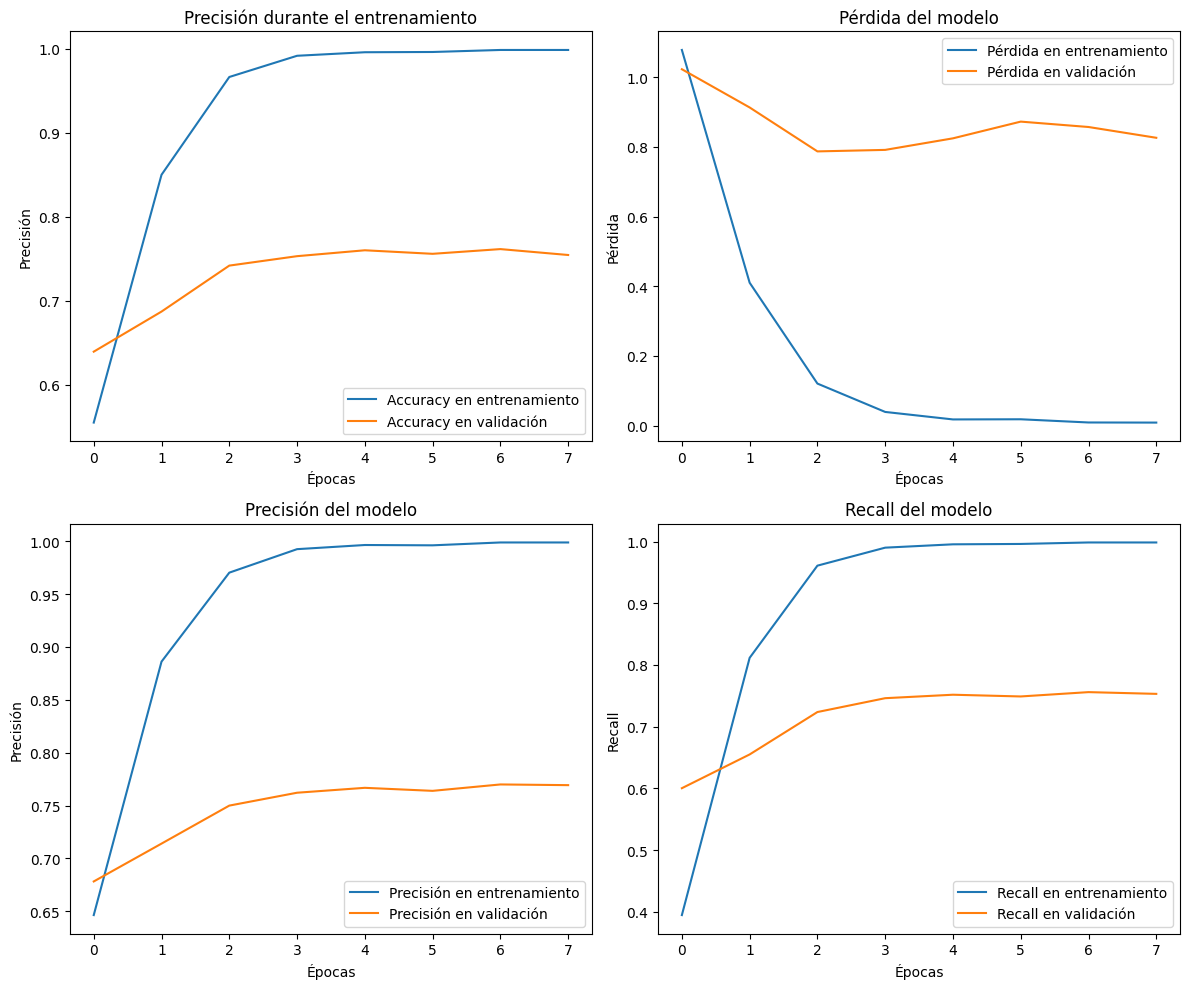

In [11]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_X.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_X.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_X.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_X.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_X.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_X.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_X.history['recall'], label='Recall en entrenamiento')
plt.plot(history_X.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

In [12]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

23/23 [==============================] - 17s 751ms/step - loss: 0.8600 - accuracy: 0.7301 - precision: 0.7496 - recall: 0.7077 - auc: 0.9272
Test Loss: 0.8599997162818909
Test Accuracy: 0.7300699353218079
Test Precision: 0.7496296167373657
Test Recall: 0.7076923251152039
Test AUC: 0.9271871447563171


**Matriz de confusión**

23/23 [==============================] - 18s 749ms/step


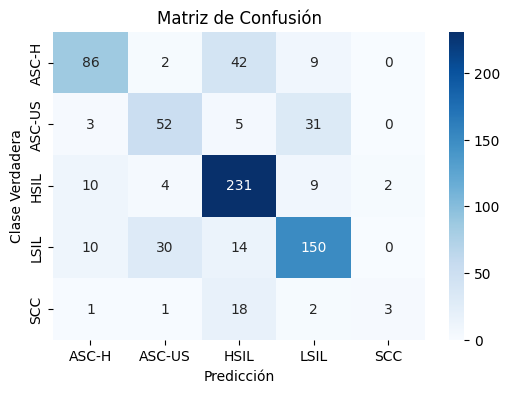

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

23/23 [==============================] - 17s 741ms/step


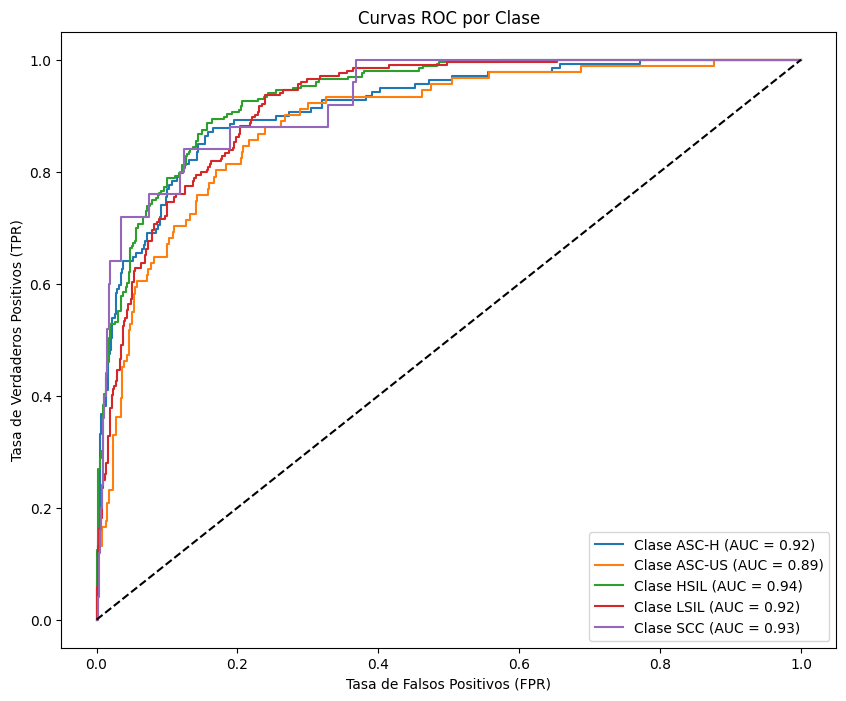

AUC Promedio: 0.92
AUC Promedio Ponderado: 0.92


In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')


# Con balanceo de clases

## Generación de Datos

##### Grafico de la distribución de las clases con aumentación

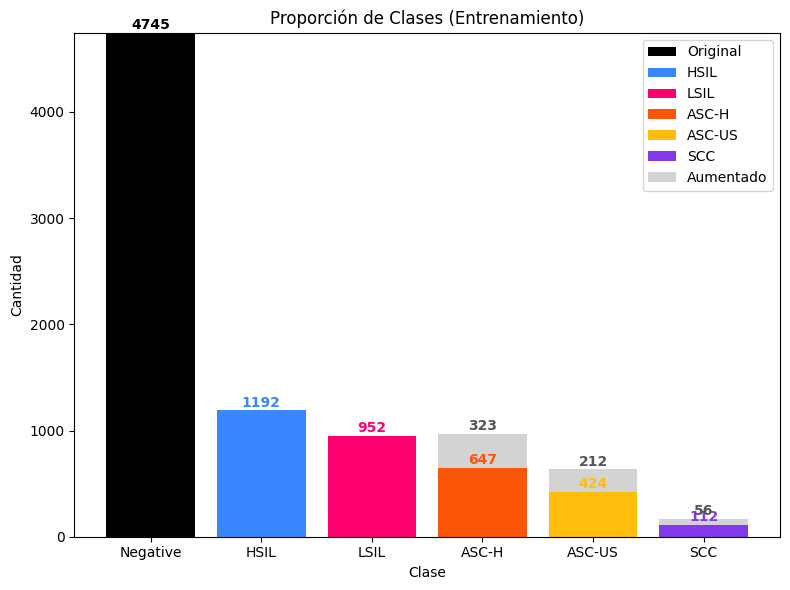

In [35]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes originales y aumentadas por clase en el conjunto de entrenamiento
def count_images_by_class_with_augmentation(folder_path):
    class_counts = {}
    augmented_counts = {}

    # Contar imágenes en la carpeta "0_no_lesion/Negative"
    no_lesion_folder = os.path.join(folder_path, '0_no_lesion', 'Negative')
    class_counts['Negative'] = len([img for img in os.listdir(no_lesion_folder) if "_aug_" not in img]) if os.path.exists(no_lesion_folder) else 0
    augmented_counts['Negative'] = len([img for img in os.listdir(no_lesion_folder) if "_aug_" in img]) if os.path.exists(no_lesion_folder) else 0

    # Contar imágenes en cada subcarpeta de "1_lesion"
    lesion_folder = os.path.join(folder_path, '1_lesion')
    for lesion_class in os.listdir(lesion_folder):
        lesion_class_path = os.path.join(lesion_folder, lesion_class)
        if os.path.isdir(lesion_class_path):
            class_counts[lesion_class] = len([img for img in os.listdir(lesion_class_path) if "_aug_" not in img])
            augmented_counts[lesion_class] = len([img for img in os.listdir(lesion_class_path) if "_aug_" in img])

    return class_counts, augmented_counts

# Función para crear el gráfico de barras del conjunto de entrenamiento, incluyendo aumentación
def plot_class_proportion_with_augmentation(class_counts, augmented_counts, title, colors):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    augmented = [augmented_counts[cls] for cls in classes]

    # Graficar datos originales y augmentados
    bars_original = ax.bar(classes, counts, color=colors[:len(classes)], label=['Original', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC'])
    bars_augmented = ax.bar(classes, augmented, bottom=counts, color='#D3D3D3', label='Aumentado')  # Color gris claro para aumentados

    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)

    # Agregar etiquetas de cantidad en las barras, con el color de cada barra
    for bar, count, color in zip(bars_original, counts, colors):
        ax.text(bar.get_x() + bar.get_width() / 2, count + 5, str(count), ha='center', va='bottom', fontweight='bold', color=color)
    
    for bar, count, aug in zip(bars_augmented, counts, augmented):
        if aug > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, count + aug + 5, str(aug), ha='center', va='bottom', fontweight='bold', color='#555555')

    # Añadir leyenda y mostrar gráfico
    ax.legend()
    plt.tight_layout()
    plt.show()

# Directorio de entrenamiento
train_dir = 'crops_aug/train'

# Contar las imágenes en el conjunto de entrenamiento
train_class_counts, train_augmented_counts = count_images_by_class_with_augmentation(train_dir)

# Colores para cada clase
colors = ['#000000', '#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC']

# Crear gráfico solo del conjunto de entrenamiento con datos aumentados
plot_class_proportion_with_augmentation(train_class_counts, train_augmented_counts, 'Proporción de Clases (Entrenamiento)', colors)

### Generadores

Generadores viejos con imagenes 90x90 `borrar`

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Configuración de los generadores de datos sin aumentación, solo reescalado
# train_datagen = ImageDataGenerator(rescale=1./255)
# val_test_datagen = ImageDataGenerator(rescale=1./255)

# # Generador de imágenes para entrenamiento en modo multiclase
# train_generator = train_datagen.flow_from_directory(
#     'crops_aug/train/1_lesion',  # Solo subcarpeta de lesiones
#     target_size=(90, 90),
#     batch_size=32,
#     class_mode='categorical',  # Clasificación multiclase
#     shuffle=True
# )

# # Generador de imágenes para validación en modo multiclase
# val_generator = val_test_datagen.flow_from_directory(
#     'crops_aug/val/1_lesion',  # Solo subcarpeta de lesiones
#     target_size=(90, 90),
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=False
# )

# # Generador de imágenes para prueba en modo multiclase
# test_generator = val_test_datagen.flow_from_directory(
#     'crops_aug/test/1_lesion',  # Solo subcarpeta de lesiones
#     target_size=(90, 90),
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=False
# )

Found 3918 images belonging to 5 classes.
Found 713 images belonging to 5 classes.
Found 715 images belonging to 5 classes.


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

# Generador de imágenes para entrenamiento en modo multiclase
train_generator_aug = train_datagen.flow_from_directory(
    'crops_5classes_aug/train',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', 
    shuffle=True
)

Found 3918 images belonging to 5 classes.


## Modelos

### Modelo InceptionV3

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten

num_classes = train_generator.num_classes

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = InceptionV3(input_shape=(90, 90, 3), include_top=False, weights='imagenet', classes= num_classes)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, outputs)


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_I_V3 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2024-10-26 18:31:17.414620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.4479 - precision: 0.6056 - recall: 0.1698 - auc: 0.7466

2024-10-26 18:32:09.941681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 56s 428ms/step - loss: 1.3675 - accuracy: 0.4479 - precision: 0.6056 - recall: 0.1698 - auc: 0.7466 - val_loss: 1.2615 - val_accuracy: 0.5231 - val_precision: 0.6576 - val_recall: 0.1697 - val_auc: 0.8035 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - 44s 418ms/step - loss: 1.1103 - accuracy: 0.5503 - precision: 0.6739 - recall: 0.3622 - auc: 0.8419 - val_loss: 1.0100 - val_accuracy: 0.5933 - val_precision: 0.7136 - val_recall: 0.4264 - val_auc: 0.8714 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - 44s 418ms/step - loss: 0.9941 - accuracy: 0.5846 - precision: 0.6755 - recall: 0.4442 - auc: 0.8738 - val_loss: 0.9666 - val_accuracy: 0.6255 - val_precision: 0.7290 - val_recall: 0.4979 - val_auc: 0.8836 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - 44s 419ms/step - loss: 0.8798 - accuracy: 0.6435 - precision: 0.7211 - recall: 0.5332 - auc: 0.9010 - val_loss: 0.9016 - val_accu

#### Evaluación

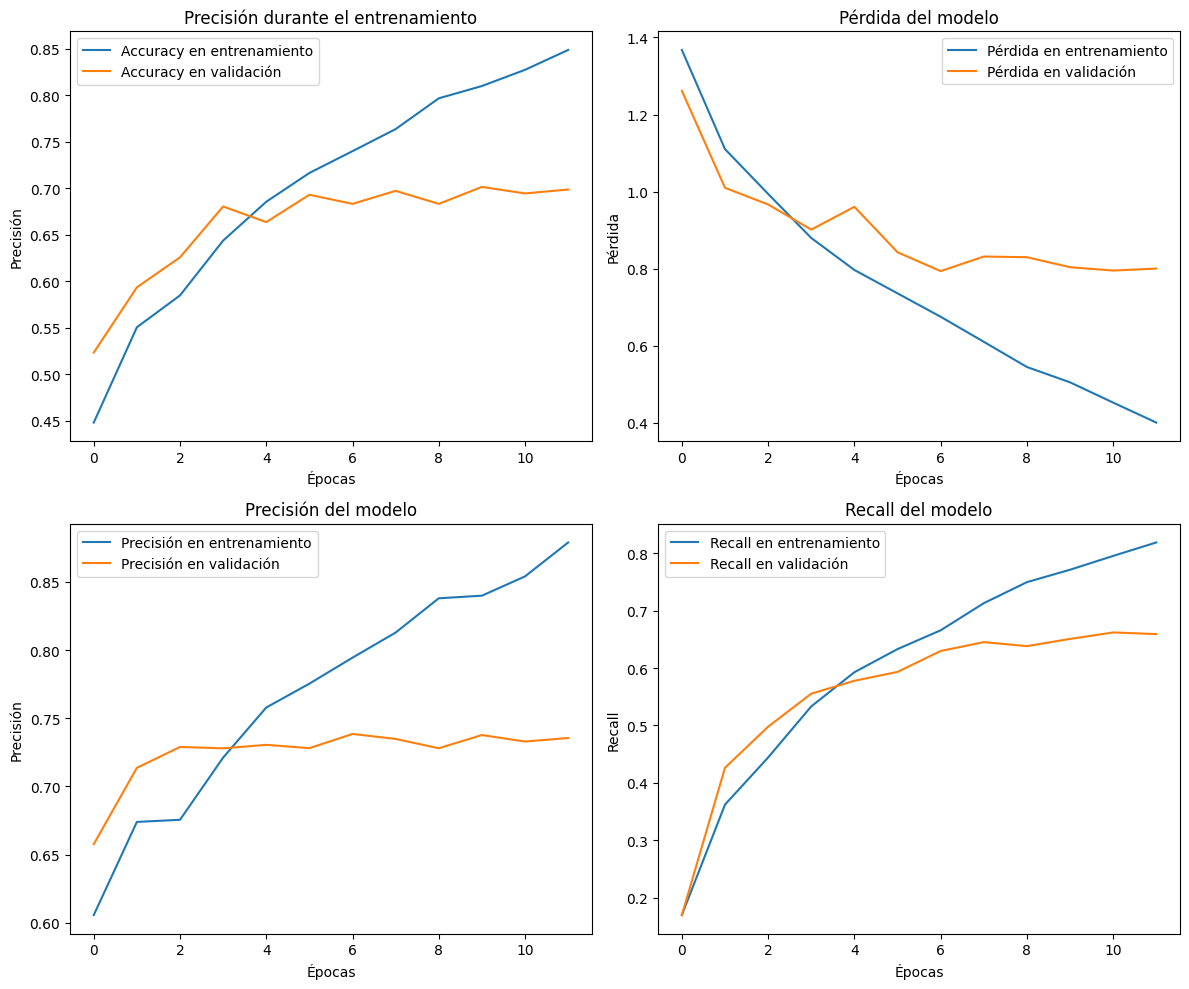

In [ ]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_I_V3.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_I_V3.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_I_V3.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_I_V3.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_I_V3.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_I_V3.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_I_V3.history['recall'], label='Recall en entrenamiento')
plt.plot(history_I_V3.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

 1/23 [>.............................] - ETA: 3s - loss: 0.9705 - accuracy: 0.6250 - precision: 0.6818 - recall: 0.4688 - auc: 0.8822

2024-10-26 18:40:12.591987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 2s 102ms/step - loss: 0.8915 - accuracy: 0.6434 - precision: 0.7031 - recall: 0.5664 - auc: 0.9013
Test Loss: 0.891455352306366
Test Accuracy: 0.6433566212654114
Test Precision: 0.703125
Test Recall: 0.5664335489273071
Test AUC: 0.9013352394104004


**Matriz de confusión**

2024-10-26 18:40:15.034859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 3s 103ms/step


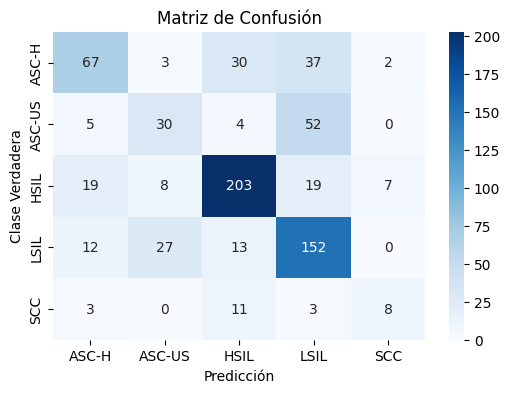

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

 1/23 [>.............................] - ETA: 3s

2024-10-26 18:40:18.498228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 2s 103ms/step


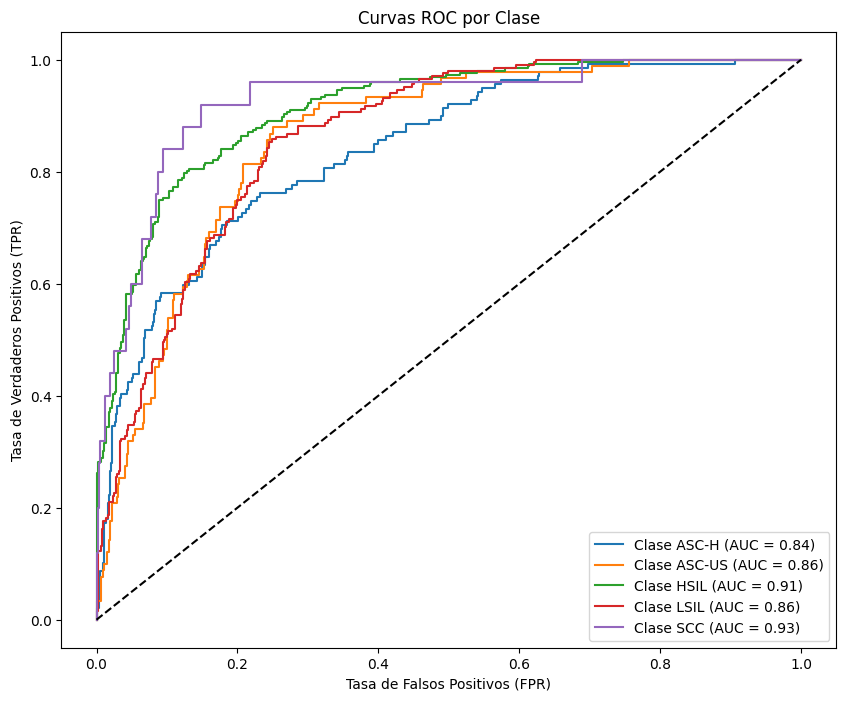

AUC Promedio: 0.88
AUC Promedio Ponderado: 0.88


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo Xception

In [24]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten

num_classes = train_generator_aug.num_classes

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = Xception(input_shape=(224, 224, 3), include_top=False, weights='imagenet', classes= num_classes)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, outputs)


# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Configurar callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# checkpoint = ModelCheckpoint('mejor_modelo_lesiones.h5', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo
history_X = model.fit(
    train_generator_aug,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

Epoch 1/30
123/123 [==============================] - 570s 5s/step - loss: 1.0832 - accuracy: 0.5564 - precision: 0.6609 - recall: 0.3675 - auc: 0.8508 - val_loss: 0.8201 - val_accuracy: 0.6550 - val_precision: 0.7158 - val_recall: 0.5652 - val_auc: 0.9124 - lr: 1.0000e-04
Epoch 2/30
123/123 [==============================] - 593s 5s/step - loss: 0.5009 - accuracy: 0.7973 - precision: 0.8255 - recall: 0.7545 - auc: 0.9669 - val_loss: 0.8477 - val_accuracy: 0.6928 - val_precision: 0.7221 - val_recall: 0.6816 - val_auc: 0.9256 - lr: 1.0000e-04
Epoch 3/30
123/123 [==============================] - 629s 5s/step - loss: 0.2360 - accuracy: 0.9068 - precision: 0.9216 - recall: 0.8936 - auc: 0.9921 - val_loss: 0.7786 - val_accuracy: 0.7672 - val_precision: 0.7797 - val_recall: 0.7546 - val_auc: 0.9403 - lr: 1.0000e-04
Epoch 4/30
123/123 [==============================] - 578s 5s/step - loss: 0.1794 - accuracy: 0.9306 - precision: 0.9380 - recall: 0.9186 - auc: 0.9955 - val_loss: 1.0547 - val_a

#### Evaluación

In [31]:
model.save('modelosFinales/xception_clasificacion5clases_aug.keras')

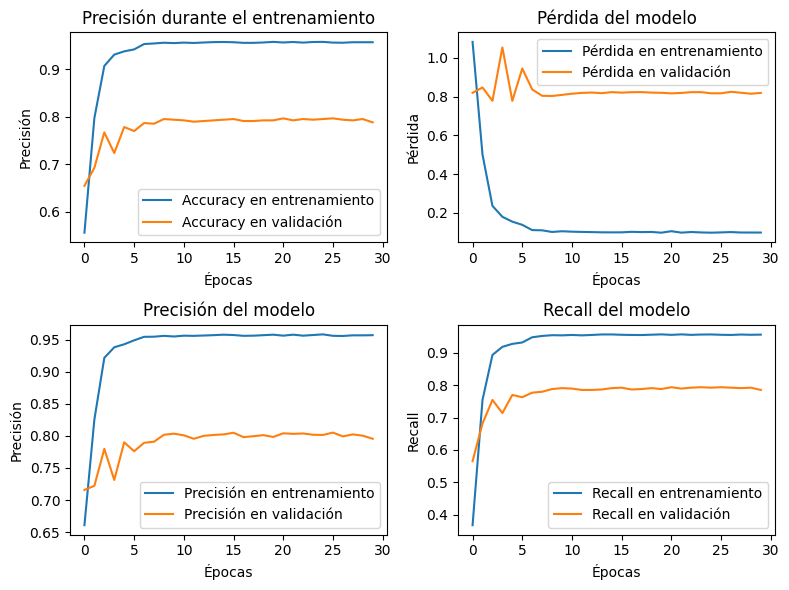

In [25]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(8, 6))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history_X.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history_X.history['val_accuracy'], label='Accuracy en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history_X.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_X.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history_X.history['precision'], label='Precisión en entrenamiento')
plt.plot(history_X.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history_X.history['recall'], label='Recall en entrenamiento')
plt.plot(history_X.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

In [26]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

# 23/23 [==============================] - 17s 753ms/step - loss: 0.7648 - accuracy: 0.7399 - precision: 0.7604 - recall: 0.7147 - auc: 0.9365
# Test Loss: 0.7648487687110901
# Test Accuracy: 0.7398601174354553
# Test Precision: 0.7604166865348816
# Test Recall: 0.714685320854187
# Test AUC: 0.9364643692970276

23/23 [==============================] - 18s 762ms/step - loss: 0.9595 - accuracy: 0.7608 - precision: 0.7642 - recall: 0.7524 - auc: 0.9393
Test Loss: 0.9595494270324707
Test Accuracy: 0.7608391642570496
Test Precision: 0.7642045617103577
Test Recall: 0.7524475455284119
Test AUC: 0.9392820596694946


**Matriz de confusión**

23/23 [==============================] - 20s 825ms/step


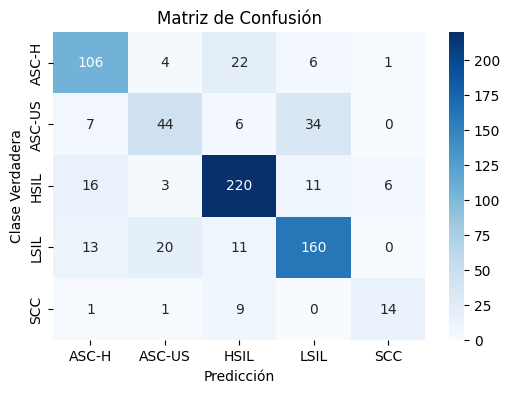

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

**Curva ROC**

23/23 [==============================] - 20s 844ms/step


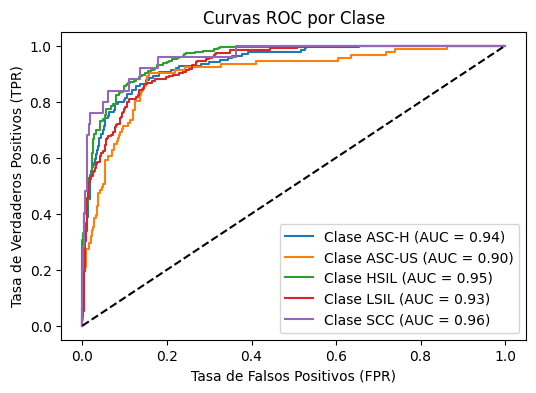

AUC Promedio: 0.94
AUC Promedio Ponderado: 0.94


In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(6, 4))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')
